In [1]:
from Bayesian_Neural_Network import bayesian_neural_network
from BNN_Learning_Rate_Tuning import bnn_learning_rate_tuning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(10120024)

# Data Preparation

In [2]:
# load the dataset
df = pd.read_csv('fraud.csv', 
                    usecols=['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud'], 
                    nrows=250)

# perform one-hot-eencoding on the column 'type'
dummies_df = pd.get_dummies(df['type'], dtype=int)

# concat the original data with the one-hot-encoded data
data = pd.concat((df, dummies_df), axis=1) \
            .drop(columns=['type'])

# perform min-max standarization
for col in data.columns:
    data[col] -= np.min(data[col]) 
    data[col] /= np.max(data[col])

# augment the fraud data
final_data = data.copy()
for _ in range(20):
    final_data = pd.concat((final_data, data.loc[data['isFraud'] == 1, :]))

In [3]:
# percentage of fraud and non-fraud label in the data
final_data['isFraud'].value_counts().to_frame('percentage') / np.sum(final_data['isFraud'].value_counts()) * 100

,percentage
isFraud,
0.0,85.517241
1.0,14.482759


In [4]:
# specify the feature and target data
feature_columns = final_data.columns[:-1]
target_columns = final_data.columns[-1]

feature_data = final_data.loc[:, feature_columns].values
target_data = final_data.loc[:, target_columns].values

# Model Performance On The Data

In [ ]:
input_layer = [len(feature_columns)]
hidden_layers = [16, 8, 4, 2]
output_layer = [1]

total_epochs = 250
learning_rate = 1e-40

error_type = 'accuracy'
learning_rate_decay_type = 'exponential'

In [ ]:
bnn = bayesian_neural_network(input_layer, hidden_layers, output_layer, feature_data, target_data, error_type, learning_rate=learning_rate)
bnn.standardize_dataset()
bnn.generate_m()
bnn.generate_v()

In [ ]:
bnn.train_model(total_epochs)

In [ ]:
bnn.visualize_performance()

# Model Learning Rate Tuning

In [12]:
input_layer = [len(feature_columns)]
hidden_layers = [32, 16, 8, 4, 2]
output_layer = [1]

initial_lr_power = 30
end_lr_power = 35
total_iters = 5
tuning_epochs = 10

error_type = 'accuracy'

In [13]:
bnn_lr_tuning = bnn_learning_rate_tuning(input_layer, 
                                         hidden_layers, 
                                         output_layer, 
                                         feature_data, 
                                         target_data,
                                         error_type=error_type, 
                                         initial_lr_power=initial_lr_power, 
                                         end_lr_power=end_lr_power, 
                                         total_iters=total_iters, 
                                         tuning_epochs=tuning_epochs)

In [14]:
bnn_lr_tuning.perform_learning_rate_tuning()

------------------------------------------------------------------------------------------------------------------------------------------------------
Iterations : 1 / 5 - Learning Rate : 1e-30 - Succesfull Train Percentage : 100.0% - Time Passed : 7.22 Second
Accuracy : 83.10344827586206% - Standard Deviation : 8.20397199628444e-09
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Iterations : 2 / 5 - Learning Rate : 1e-31 - Succesfull Train Percentage : 100.0% - Time Passed : 7.14 Second
Accuracy : 83.44827586206897% - Standard Deviation : 6.03353304896651e-11
------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------

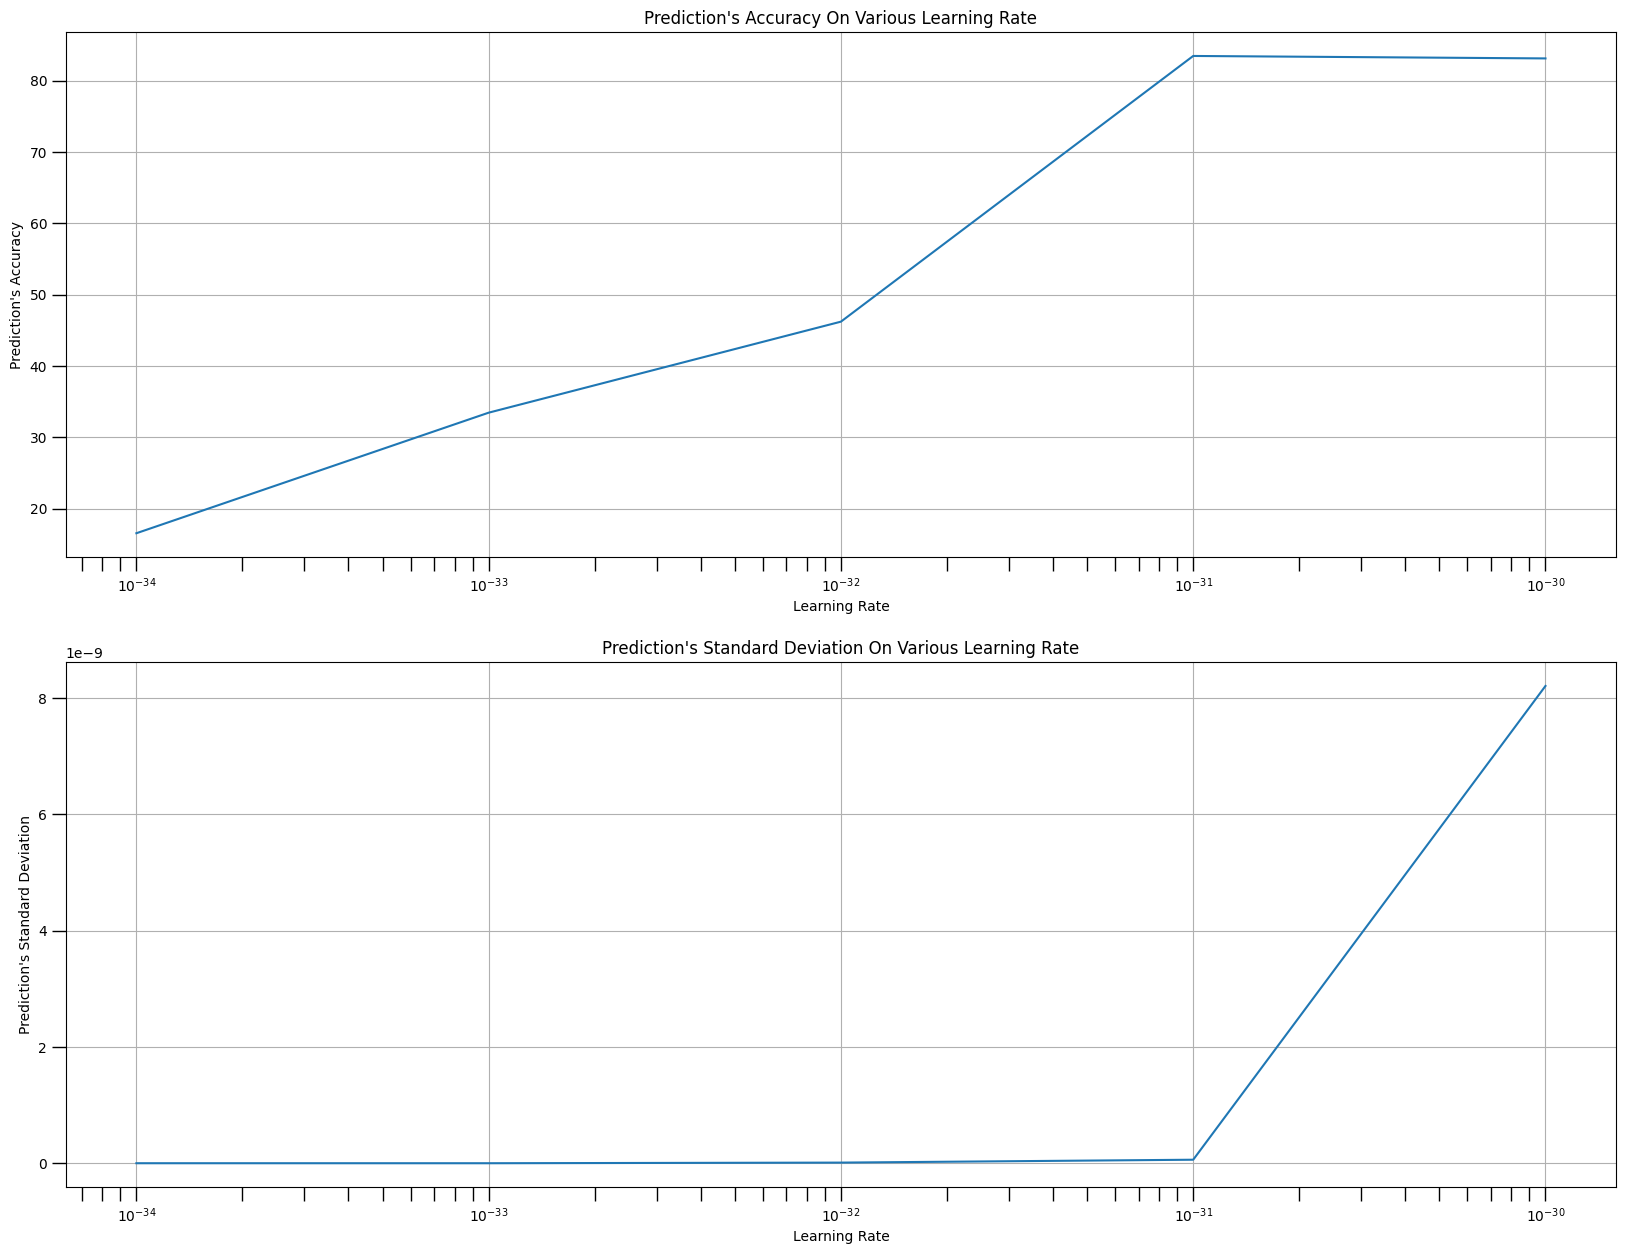

In [15]:
bnn_lr_tuning.visualize_learning_rate_tuning()